In [ ]:
class Config():
  def __init__(
    self,
    num_classes,
    num_epochs,
    batch_size,
    learning_rate,
    early_stopping_patience,
    early_stopping_min_delta,
    use_saved_models,
    train_size,
    test_size,
    val_size,
    filename_prefix,
    poster_shape,
  ):
    self.num_classes = num_classes
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.early_stopping_patience = early_stopping_patience
    self.early_stopping_min_delta = early_stopping_min_delta

    self.use_saved_models = use_saved_models

    self.train_size = train_size
    self.test_size = test_size
    self.val_size = val_size

    self.filename_prefix = filename_prefix

    self.poster_shape = poster_shape

cfg = Config(
    num_classes=4,
    num_epochs=100, # Due to dropout
    batch_size = 64,
    learning_rate = 0.01,
    early_stopping_patience = 10, # Due to dropout
    early_stopping_min_delta = 0.01,
    use_saved_models = False,
    train_size = 0.9,
    test_size = 0.05,
    val_size = 0.05,
    filename_prefix = '3_bor_poster_prereleased_own/',
    poster_shape = (268, 182),
)

# Обработка данных

## Очистка

In [18]:
import pandas as pd
import numpy as np
from ast import literal_eval
from dateutil.parser import parse
from pathlib import Path

df = pd.read_csv('./movie_dataset.csv', index_col=0)

to_drop = [
    'id',
    'tagline',
    'overview',
    'vote_average',
    'vote_count',
    'domestic_opening',
    'original_title',
    'title',
    'spoken_languages',
    'original_language',
]
df = df.drop(columns=to_drop)

df['budget'] = df['budget'].replace({0: np.nan})
df['revenue'] = df['revenue'].replace({0: np.nan})
df['runtime'] = df['runtime'].replace({0: np.nan})

df.dropna(inplace=True)
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

df['production_company'] = df.apply(lambda x: x['production_companies'][0], axis=1)
df['production_country'] = df.apply(lambda x: x['production_countries'][0], axis=1)
df = df.drop(columns=['production_companies', 'production_countries'], axis=1)

to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

df = df[df['actors'].map(len) == 3]
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)

m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

posters = Path('./posters')
imdb_ids = [x.name[:-len('.jpg')] for x in posters.glob('*.jpg')]
df = df[df['imdb_id'].isin(imdb_ids)]
df['poster'] = df.apply(lambda x: f'./posters/{x["imdb_id"]}.jpg', axis=1)

df = df.drop(columns=['imdb_id'], axis=1)

## Формирование целевой переменной

In [ ]:
def get_class(row):
  R = row['revenue']
  B = row['budget']
  if R < B:
    return 0
  elif B <= R < 2*B:
    return 1
  elif 2*B <= R < 4*B:
    return 2
  elif 4*B <= R:
    return 3
  return np.NAN
  # R = row['revenue']
  # if R <= 5000000:
  #   return 0
  # elif 5000000 < R <= 20000000:
  #   return 1
  # elif 20000000 < R <= 60000000:
  #   return 2
  # elif 60000000 < R <= 145000000:
  #   return 3
  # elif 145000000 < R:
  #   return 4
  # return np.NAN

df['target'] = df.apply(get_class, axis=1)
df = df.drop(columns=['revenue'], axis=1)

## Извлечение и преобразование признаков

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        # Жанры
        self.genres_mlb = MultiLabelBinarizer().fit(X['genres'].values)
        # Продюсерская компания
        self.production_company_encoder = LabelEncoder().fit(X['production_company'].values)
        # Страна производства
        self.production_country_encoder = LabelEncoder().fit(X['production_country'].values)
        # Дистрибьютор
        self.domestic_distributor_encoder = LabelEncoder().fit(X['domestic_distributor'].values)
        # Режиссер
        self.director_encoder = LabelEncoder().fit(X['director'].values)
        # Актеры
        unique_actors = pd.concat([df['actor_1'], df['actor_2'], df['actor_3']]).unique()
        self.actor_encoder = LabelEncoder().fit(unique_actors)
        # Месяц выхода
        self.release_month_encoder = OneHotEncoder(sparse_output=False).fit(X['release_month'].values.reshape(-1, 1))
        # Возрастной рейтинг
        self.mpaa_encoder = OneHotEncoder(sparse_output=False).fit(X['mpaa'].values.reshape(-1, 1))
        # Бюджет
        self.budget_scaler = StandardScaler().fit(X['budget'].values.reshape(-1, 1))
        # Длительность
        self.runtime_scaler = StandardScaler().fit(X['runtime'].values.reshape(-1, 1))

        self.columns_order = [
            'actor_1', 'actor_2', 'actor_3', 'director', 'production_company', 'production_country', 'domestic_distributor',
            'runtime', 'budget', 'poster',
            'genre_action', 'genre_adventure', 'genre_animation',
            'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
            'genre_family', 'genre_fantasy', 'genre_foreign', 'genre_history',
            'genre_horror', 'genre_music', 'genre_mystery', 'genre_romance',
            'genre_science_fiction', 'genre_thriller', 'genre_war', 'genre_western',
            'release_month_1', 'release_month_2', 'release_month_3',
            'release_month_4', 'release_month_5', 'release_month_6',
            'release_month_7', 'release_month_8', 'release_month_9',
            'release_month_10', 'release_month_11', 'release_month_12',
            'mpaa_G', 'mpaa_NC-17', 'mpaa_PG', 'mpaa_PG-13', 'mpaa_R'
        ]

        return self

    def transform(self, X):
        # Жанры
        classes = [f'genre_{x.replace(" ", "_").lower()}' for x in self.genres_mlb.classes_]
        transformed_genres = self.genres_mlb.transform(X['genres'].values)
        X = X.join(pd.DataFrame(transformed_genres.astype(bool), X.index, classes))
        X = X.drop(columns=['genres'], axis=1)
        # Продюсерская компания
        X['production_company'] = self.production_company_encoder.transform(X['production_company'].values)
        # Страна производства
        X['production_country'] = self.production_country_encoder.transform(X['production_country'].values)
        # Дистрибьютор
        X['domestic_distributor'] = self.domestic_distributor_encoder.transform(X['domestic_distributor'].values)
        # Режиссер
        X['director'] = self.director_encoder.transform(X['director'].values)
        # Актеры
        for i in range(1, 4):
            X[f'actor_{i}'] = self.actor_encoder.transform(X[f'actor_{i}'].values)
        # Месяц выхода
        classes = [f'release_month_{x}' for x in self.release_month_encoder.categories_[0]]
        transfored_release_month = self.release_month_encoder.transform(X['release_month'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_release_month.astype(bool), X.index, classes))
        X = X.drop(columns=['release_month'], axis=1)
        # Возрастной рейтинг
        classes = [('mpaa_' + x.upper()) for x in self.mpaa_encoder.categories_[0]]
        transfored_mpaa = self.mpaa_encoder.transform(X['mpaa'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_mpaa.astype(bool), X.index, classes))
        X = X.drop(columns=['mpaa'], axis=1)
        # Бюджет
        X['budget'] = self.budget_scaler.transform(X['budget'].values.reshape(-1, 1))
        # Длительность
        X['runtime'] = self.runtime_scaler.transform(X['runtime'].values.reshape(-1, 1))

        X = X[self.columns_order]

        return X

preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', PreprocessingTransformer()),
])

X = df.drop(columns=['target'], axis=1)
y = df['target'].to_numpy()

# Fit and evaluate the model
X = preprocess_pipeline.fit_transform(X, y)

### Сохранение преобразования признаков

In [21]:
import dill

with open(f'{cfg.filename_prefix}/pipeline.pkl', 'wb') as f:
    dill.dump(preprocess_pipeline, f, protocol=5)

# Построение и обучение моделей

## Вспомогательная функциональность

Опишем фукнцию, которая будет оценивать получившуюся модель

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

results = {}

# Функция для оценки полученной модели
def inspect_model(model, test_generator, y_true, model_name, history=None):
  predictions = model.predict(test_generator)
  # real_classes = y.argmax(axis=1)
  real_classes = y_true
  predicted_classes = predictions.argmax(axis=1)

  # Exact and 1-class-away accuracy
  real_classes = real_classes[:min(real_classes.shape[0], predicted_classes.shape[0])]
  predicted_classes = predicted_classes[:min(real_classes.shape[0], predicted_classes.shape[0])]

  diffs = abs(real_classes - predicted_classes)

  exact_match = len(diffs[diffs <= 0]) / len(diffs)
  one_class_away = len(diffs[diffs <= 1]) / len(diffs)
  print('Exact match accuracy:', exact_match)
  print('One class away accuracy:', one_class_away)

  # Precision and recall
  precision = precision_score(real_classes, predicted_classes, average=None)
  recall = recall_score(real_classes, predicted_classes, average=None)
  f1 = f1_score(real_classes, predicted_classes, average=None)
  print("Precision per class:", precision)
  print("Recall per class:", recall)
  print("F1 score per class", f1)

  # Macro and Micro averaged Precision and Recall
  macro_precision = precision_score(real_classes, predicted_classes, average='macro')
  macro_recall = recall_score(real_classes, predicted_classes, average='macro')
  micro_precision = precision_score(real_classes, predicted_classes, average='micro')
  micro_recall = recall_score(real_classes, predicted_classes, average='micro')
  macro_f1 = f1_score(real_classes, predicted_classes, average='macro')
  micro_f1 = f1_score(real_classes, predicted_classes, average='micro')

  print("Macro Precision:", macro_precision)
  print("Macro Recall:", macro_recall)
  print("Macro F1:", macro_f1)
  print("Micro Precision:", micro_precision)
  print("Micro Recall:", micro_recall)
  print("Micro F1:", micro_f1)

  # Confusion matrix
  m = confusion_matrix(real_classes, predicted_classes)
  ConfusionMatrixDisplay(m).plot()

  if (history != None):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss Function Over Epochs')
    ax.set_ylabel('Sparse Categorical Crossentropy value')
    ax.set_xlabel('No. epoch')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Accuracy Over Epochs')
    ax.set_ylabel('Accuracy value')
    ax.set_xlabel('No. epoch')
    plt.show()

  # model.summary()

  results[model_name] = {
      'exact_match': exact_match,
      'one_class_away': one_class_away,
  }

Также опишем класс, который будет отвечать за генерацию батчей с изображениями

In [23]:
from keras.utils import Sequence
from tensorflow.keras.preprocessing import image
import cv2

def load_image(
    path,
    size=(96,96)
):
    img = image.load_img(path)
    img = image.img_to_array(img)
    # img = cv2.resize(img, size)
    return img

class PosterGenerator(Sequence):
    def __init__(
        self,
        posters,
        labels,
        batch_size = 32,
        dim = (32,32),
        shuffle = True,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.posters = posters
        self.labels = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.posters))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.posters) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        X = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int64)

        for i, idx in enumerate(indexes):
            X[i,] = load_image(
                path=self.posters[idx],
                size=self.dim,
            )
            y[i] = self.labels[idx]

        return X, y

Опишем класс для генерации данных для таблично-постерной модели

In [24]:
from keras.utils import Sequence
from tensorflow.keras.preprocessing import image
import cv2

def load_image(
    path,
    size=(96,96)
):
    img = image.load_img(path)
    img = image.img_to_array(img)
    # img = cv2.resize(img, size)
    return img

class TabularPosterGenerator(Sequence):
    def __init__(
        self,
        tabular,
        posters,
        labels,
        batch_size = 32,
        dim = (32,32),
        shuffle = True,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.tabular = tabular
        self.posters = posters
        self.labels = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.posters))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.posters) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Xt = np.empty((self.batch_size, self.tabular.shape[1]), dtype=np.float32)
        Xp = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int64)

        for i, idx in enumerate(indexes):
            Xt[i,] = self.tabular[idx]
            Xp[i,] = load_image(
                path=self.posters[idx],
                size=self.dim,
            )
            y[i] = self.labels[idx]

        return (Xt, Xp), y

Кастомные слой для построения моделей

In [25]:
import tensorflow as tf
import keras

@keras.saving.register_keras_serializable()
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, start_index, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.start_index = start_index

    def call(self, inputs):
        # Your custom slicing logic goes here
        return inputs[:, self.start_index:]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({
            "start_index": self.start_index,
        })
        return config

@keras.saving.register_keras_serializable()
class IndexAndExpandLayer(tf.keras.layers.Layer):
    def __init__(self, index, **kwargs):
        super(IndexAndExpandLayer, self).__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        return tf.expand_dims(inputs[:,self.index],-1)

    def get_config(self):
        config = super(IndexAndExpandLayer, self).get_config()
        config.update({
            "index": self.index,
        })
        return config


Кастомная метрика для отображения "1-class-away" точности

In [26]:
import tensorflow as tf

# Define the custom metric
@keras.saving.register_keras_serializable()
class OneClassAwayAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='one_class_away_accuracy', **kwargs):
        super(OneClassAwayAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class indices
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.squeeze(y_true)

        # Determine correct predictions within one class
        correct = tf.cast(
            tf.math.logical_or(
                tf.equal(y_true, y_pred),
                tf.logical_or(
                    tf.equal(y_true, y_pred + 1),
                    tf.equal(y_true, y_pred - 1)
                )
            ),
            tf.float32
        )

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            correct = tf.multiply(correct, sample_weight)

        self.total.assign_add(tf.reduce_sum(correct))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

Расчет весов классов

In [27]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = {i: x for i, x in enumerate(class_weights)}

Разбиваем исходный датасет следующим образом: 90% - тренировочный, 5% - валидационный, 5% - тестовый.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=1-cfg.train_size, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum, test_size=cfg.test_size/(cfg.test_size + cfg.val_size), stratify=y_dum)

print('Train size:', cfg.train_size)
print('Test size:', (1-cfg.train_size) * cfg.test_size/(cfg.test_size + cfg.val_size))
print('Val size:', (1-cfg.train_size) * cfg.val_size/(cfg.test_size + cfg.val_size))

print('Train size:', X_train.shape)
print('Test size:', X_test.shape)
print('Val size:', X_val.shape)

Train size: 0.9
Test size: 0.04999999999999999
Val size: 0.04999999999999999
Train size: (3458, 46)
Test size: (193, 46)
Val size: (192, 46)


## Архитектура табличной модели

In [ ]:
import keras
from keras import layers
from keras.models import Model
import tensorflow as tf

class AdditionalModel():
    def __init__(self, model, model_output, port, trainable):
        self.model = model
        self.model_output = model_output
        self.port = port
        self.trainable = trainable


def build_tabular_model(
    original_input_shape,
    n_unique_actors,
    n_unique_directors,
    n_unique_production_companies,
    n_unique_production_countries,
    n_unique_domestic_distributor,
    n_classes,
):
    def out_dim(n):
        return 20

    def build_embedding_cfg(name, input_dim, output_dim=out_dim(None)):
        return {
            'name': name,
            'input_dim': input_dim,
            'output_dim': output_dim,
        }

    input = layers.Input(shape=(original_input_shape,))

    embedding_cfg = [
        build_embedding_cfg('actor_1', n_unique_actors),
        build_embedding_cfg('actor_2', n_unique_actors),
        build_embedding_cfg('actor_3', n_unique_actors),
        build_embedding_cfg('director', n_unique_directors),
        build_embedding_cfg('production_company', n_unique_production_companies),
        build_embedding_cfg('production_country', n_unique_production_countries),
        build_embedding_cfg('domestic_distributor', n_unique_domestic_distributor),
    ]

    embedding_outputs = []
    for i, cfg in enumerate(embedding_cfg):
        embedded_lambda = IndexAndExpandLayer(i)(input)
        embedding = layers.Embedding(
            input_dim=cfg['input_dim'],
            output_dim=cfg['output_dim'],
            name=cfg['name'],
        )(embedded_lambda)
        output = layers.Flatten()(embedding)

        embedding_outputs.append(output)

    other_lambda = SliceLayer(len(embedding_cfg))(input)

    to_concat = [
        *embedding_outputs,
        other_lambda
    ]

    merged = layers.concatenate(to_concat)

    hidden = layers.Dense(96, activation='relu')(merged)
    hidden = layers.Dropout(0.4)(hidden)
    hidden = layers.Dense(64, activation='relu')(hidden)

    hidden = layers.Dropout(0.4)(hidden)
    hidden = layers.Dense(32, activation='relu')(hidden)
    hidden = layers.Dropout(0.4)(hidden)
    hidden = layers.Dense(16, activation='relu')(hidden)

    output = layers.Dense(n_classes, activation='softmax')(hidden)

    inputs = input

    model = Model(inputs=inputs, outputs=output)

    return model

## Архитектура модели для постеров

In [ ]:
from keras import layers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.optimizers import Adagrad, Adam
import dill

class PosterModelWrapper():
    def __init__(self, input_shape, n_classes):
        inp = layers.Input(shape=input_shape)

        hidden = layers.Conv2D(64, 3, activation='relu')(inp)
        hidden = layers.Conv2D(64, 3, activation='relu')(hidden)
        hidden = layers.MaxPooling2D(pool_size=(2, 2))(hidden)

        hidden = layers.Conv2D(128, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(128, 3, activation="relu")(hidden)
        hidden = layers.MaxPooling2D(pool_size=(2, 2))(hidden)

        hidden = layers.Conv2D(256, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(256, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(256, 3, activation="relu")(hidden)
        hidden = layers.MaxPooling2D(pool_size=(3, 3))(hidden)

        hidden = layers.Conv2D(512, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(512, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(512, 3, activation="relu")(hidden)

        hidden = layers.GlobalAveragePooling2D()(hidden)

        hidden = layers.Dense(128, activation='relu', name='last')(hidden)

        out = layers.Dense(n_classes, activation='softmax')(hidden)

        model = Model(inputs=inp, outputs=out)

        self.model = model

    def train(
        self,
        train_generator,
        val_generator,
        class_weights,
        epochs,
        checkpoint_path,
    ):
        optimizer = Adagrad(
            learning_rate=cfg.learning_rate,
        )
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy', OneClassAwayAccuracy()],
        )

        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
        # Настраиваем callback для ранней остановки модели
        early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
        # Настраиваем callback для TensorBoardd
        tensorboard = TensorBoard(log_dir="./logs")

        # Обучение модели
        full_history = self.model.fit(
            x=train_generator,
            validation_data=val_generator,
            epochs=epochs,
            class_weights=class_weights,
            verbose=1,
            callbacks=[
                checkpoint,
                early_stopping,
                tensorboard,
            ],
        )
        best_model = load_model(checkpoint_path)

        p = Path(checkpoint_path)
        with open(f'{p.parents[0]}/{p.stem}_history.pkl', 'wb') as f:
            dill.dump(full_history, f, protocol=5)

        return best_model, full_history

### Архитектура

In [31]:
from keras.utils import plot_model

poster_model_wrapper = PosterModelWrapper(
    input_shape=(*cfg.poster_shape, 3),
    n_classes=cfg.num_classes,
)
# plot_model(poster_model_wrapper.model, show_shapes=True, show_layer_activations=True, show_layer_names=True)

### Обучение

In [ ]:
train_generator = PosterGenerator(
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
val_generator = PosterGenerator(
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,   
)

checkpoint_path = f'{cfg.filename_prefix}best_poster_own_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = poster_model_wrapper.train(
        train_generator,
        val_generator,
        class_weights,
        epochs=10,
        checkpoint_path=checkpoint_path,
    )

Epoch 1/100


2025-04-24 23:38:13.455086: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 784465920 exceeds 10% of free system memory.
2025-04-24 23:38:13.640222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 769916928 exceeds 10% of free system memory.
2025-04-24 23:38:14.298483: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192479232 exceeds 10% of free system memory.
2025-04-24 23:38:14.421684: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192479232 exceeds 10% of free system memory.
2025-04-24 23:38:14.521972: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 384958464 exceeds 10% of free system memory.


 2/54 ━━━━━━━━━━━━━━━━━━━━ 6:02 7s/step - accuracy: 0.2148 - loss: 17.0568 - one_class_away_accuracy: 0.5156

KeyboardInterrupt: 

### Исследование

In [33]:
best_poster_model = load_model(checkpoint_path)
with open(f'{cfg.checkpoint_path}/best_poster_own_model_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = PosterGenerator(
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_poster_model, test_generator, y_test, 'poster-only', history=full_history)

ValueError: File not found: filepath=3_bor_poster_prereleased_own/best_poster_own_model.keras. Please ensure the file is an accessible `.keras` zip file.

## Обучение вместе

In [120]:
def train(
    model,
    train_generator,
    val_generator,
    class_weights,
    checkpoint_path,
):
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
    # Настраиваем callback для TensorBoardd
    tensorboard = TensorBoard(log_dir="./logs")

    # Обучение модели
    full_history = model.fit(
        x=train_generator,
        validation_data=val_generator,
        epochs=cfg.num_epochs,
        verbose=1,
        callbacks=[
            checkpoint,
            early_stopping,
            tensorboard,
        ],
    )
    best_model = load_model(checkpoint_path)

    with open(f'./{checkpoint_path}_history.pkl', 'wb') as f:
        dill.dump(full_history, f, protocol=5)

    return best_model, full_history

### Интеграция на входном слое

In [121]:
from keras.utils import plot_model

tabular_and_poster_INPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='input',
        trainable=True,
    ),
)
plot_model(tabular_and_poster_INPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [122]:
train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)

optimizer = Adagrad(
    learning_rate=cfg.learning_rate,
)
tabular_and_poster_INPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', OneClassAwayAccuracy()],
)

best_tabular_and_poster_INPUT_model_path = f'{cfg.filename_prefix}_input.keras'
if (not Path(best_tabular_and_poster_INPUT_model_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_poster_INPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=best_tabular_and_poster_INPUT_model_path,
    )

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2767 - loss: 1.3960 - one_class_away_accuracy: 0.6201
Epoch 1: val_loss improved from inf to 1.36626, saving model to 3_bor_poster_prereleased_own_input.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.2769 - loss: 1.3960 - one_class_away_accuracy: 0.6196 - val_accuracy: 0.3438 - val_loss: 1.3663 - val_one_class_away_accuracy: 0.5469
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3199 - loss: 1.3840 - one_class_away_accuracy: 0.5751
Epoch 2: val_loss improved from 1.36626 to 1.36590, saving model to 3_bor_poster_prereleased_own_input.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.3200 - loss: 1.3838 - one_class_away_accuracy: 0.5748 - val_accuracy: 0.3438 - val_loss: 1.3659 - val_one_class_away_accuracy: 0.5417
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3260 - loss: 1.3705 - one_class_away_accuracy: 0.5411
Epoch 3: val_loss improved from 1.36590 to 1.363

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Exact match accuracy: 0.34375
One class away accuracy: 0.5416666666666666
Precision per class: [0.34375 0.      0.      0.     ]
Recall per class: [1. 0. 0. 0.]
F1 score per class [0.51162791 0.         0.         0.        ]
Macro Precision: 0.0859375
Macro Recall: 0.25
Macro F1: 0.12790697674418605
Micro Precision: 0.34375
Micro Recall: 0.34375
Micro F1: 0.34375


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


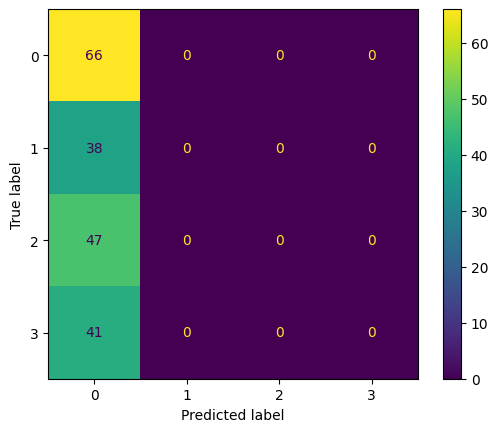

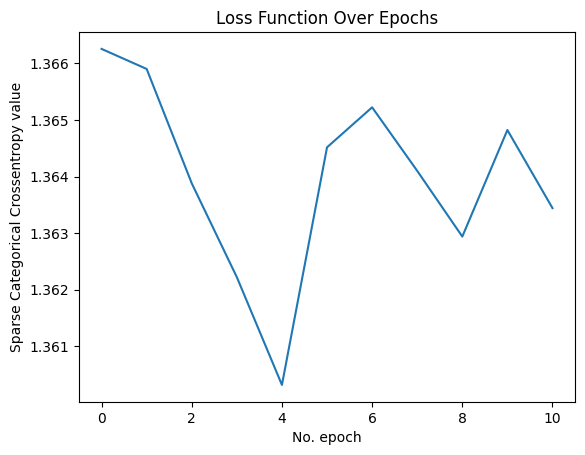

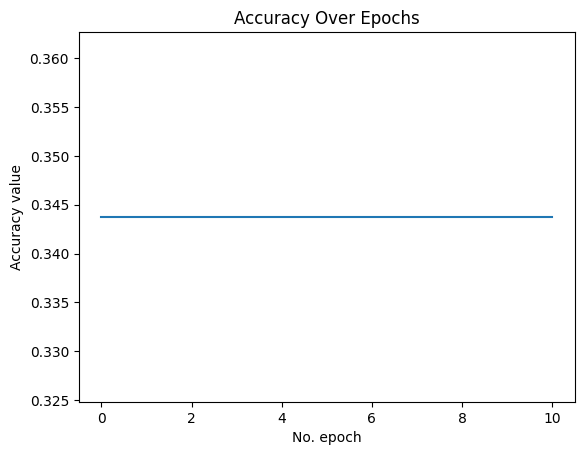

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 126,  │        448 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 42, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 40, 40,    │      4,640 │ max_pooling2d_21… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 11, 11,    │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        256 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_15[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_15[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_15[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_15[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_15[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_15[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_15[0

 Total params: 860,666 (3.28 MB)

 Trainable params: 430,220 (1.64 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 430,222 (1.64 MB)

In [123]:
best_model = load_model(best_tabular_and_poster_INPUT_model_path)
with open(f'./{best_tabular_and_poster_INPUT_model_path}_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, best_tabular_and_poster_INPUT_model_path, history=full_history)

### Интеграция на промежуточном слое

In [124]:
from keras.utils import plot_model

tabular_and_poster_MIDDLE_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='middle',
        trainable=True,
    ),
)
plot_model(tabular_and_poster_MIDDLE_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [125]:
from keras.optimizers import Adam

train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)

optimizer = Adam(
    learning_rate=cfg.learning_rate,
)
tabular_and_poster_MIDDLE_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', OneClassAwayAccuracy()],
)

best_tabular_poster_MIDDLE_model_path = f'{cfg.filename_prefix}_middle.keras'
if (not Path(best_tabular_poster_MIDDLE_model_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_poster_MIDDLE_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=best_tabular_poster_MIDDLE_model_path,
    )

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2891 - loss: 1.5497 - one_class_away_accuracy: 0.5845
Epoch 1: val_loss improved from inf to 1.36888, saving model to 3_bor_poster_prereleased_own_middle.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.2893 - loss: 1.5480 - one_class_away_accuracy: 0.5842 - val_accuracy: 0.3438 - val_loss: 1.3689 - val_one_class_away_accuracy: 0.5417
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3352 - loss: 1.3693 - one_class_away_accuracy: 0.5460
Epoch 2: val_loss improved from 1.36888 to 1.34022, saving model to 3_bor_poster_prereleased_own_middle.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.3354 - loss: 1.3692 - one_class_away_accuracy: 0.5461 - val_accuracy: 0.3438 - val_loss: 1.3402 - val_one_class_away_accuracy: 0.5417
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3703 - loss: 1.2892 - one_class_away_accuracy: 0.5933
Epoch 3: val_loss improved from 1.34022 to 1.31

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Exact match accuracy: 0.296875
One class away accuracy: 0.625
Precision per class: [0.37878788 0.         0.25396825 0.        ]
Recall per class: [0.37878788 0.         0.68085106 0.        ]
F1 score per class [0.37878788 0.         0.3699422  0.        ]
Macro Precision: 0.15818903318903318
Macro Recall: 0.2649097356544165
Macro F1: 0.18718251882991765
Micro Precision: 0.296875
Micro Recall: 0.296875
Micro F1: 0.296875


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


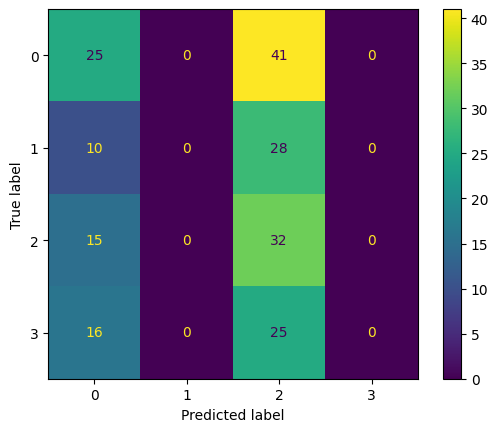

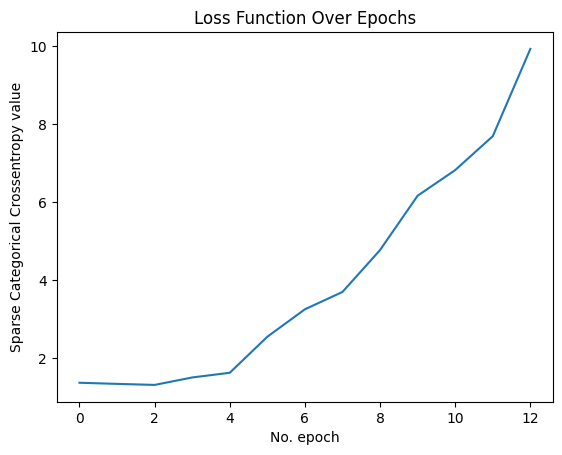

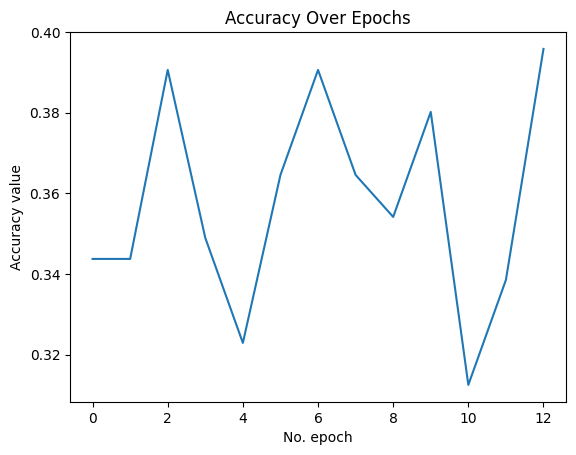

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 126,  │        448 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 42, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 40, 40,    │      4,640 │ max_pooling2d_21… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_16[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_16[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_16[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_16[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_16[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_16[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_16[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_1 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_2 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_3 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director            │ (None, 1, 20)     │     34,060 │ index_and_expand

 Total params: 1,266,310 (4.83 MB)

 Trainable params: 422,028 (1.61 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 844,058 (3.22 MB)

In [126]:
best_model = load_model(best_tabular_poster_MIDDLE_model_path)
with open(f'./{best_tabular_poster_MIDDLE_model_path}_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, best_tabular_poster_MIDDLE_model_path, history=full_history)

### Интеграция на выходном слое

In [127]:
from keras.utils import plot_model

tabular_and_poster_OUTPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='output',
        trainable=True,
    ),
)
plot_model(tabular_and_poster_OUTPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [128]:
train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)

optimizer = Adagrad(
    learning_rate=cfg.learning_rate,
)
tabular_and_poster_OUTPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', OneClassAwayAccuracy()],
)

best_tabular_and_poster_OUTPUT_model_path = f'{cfg.filename_prefix}_output.keras'
if (not Path(best_tabular_and_poster_OUTPUT_model_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_poster_OUTPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=best_tabular_and_poster_OUTPUT_model_path,
    )

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2388 - loss: 1.4950 - one_class_away_accuracy: 0.6580
Epoch 1: val_loss improved from inf to 1.36134, saving model to 3_bor_poster_prereleased_own_output.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.2393 - loss: 1.4940 - one_class_away_accuracy: 0.6571 - val_accuracy: 0.3490 - val_loss: 1.3613 - val_one_class_away_accuracy: 0.5573
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3382 - loss: 1.3842 - one_class_away_accuracy: 0.5699
Epoch 2: val_loss improved from 1.36134 to 1.36113, saving model to 3_bor_poster_prereleased_own_output.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3380 - loss: 1.3842 - one_class_away_accuracy: 0.5700 - val_accuracy: 0.3594 - val_loss: 1.3611 - val_one_class_away_accuracy: 0.5677
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3314 - loss: 1.3770 - one_class_away_accuracy: 0.5812
Epoch 3: val_loss did not improve from 1.36113


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Exact match accuracy: 0.3072916666666667
One class away accuracy: 0.515625
Precision per class: [0.33333333 0.         0.21428571 0.        ]
Recall per class: [0.84848485 0.         0.06382979 0.        ]
F1 score per class [0.47863248 0.         0.09836066 0.        ]
Macro Precision: 0.1369047619047619
Macro Recall: 0.22807865892972276
Macro F1: 0.14424828359254588
Micro Precision: 0.3072916666666667
Micro Recall: 0.3072916666666667
Micro F1: 0.3072916666666667


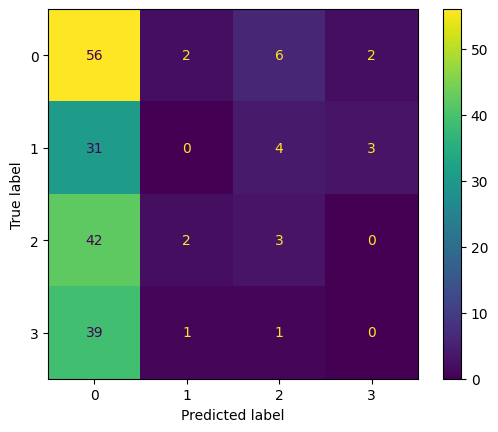

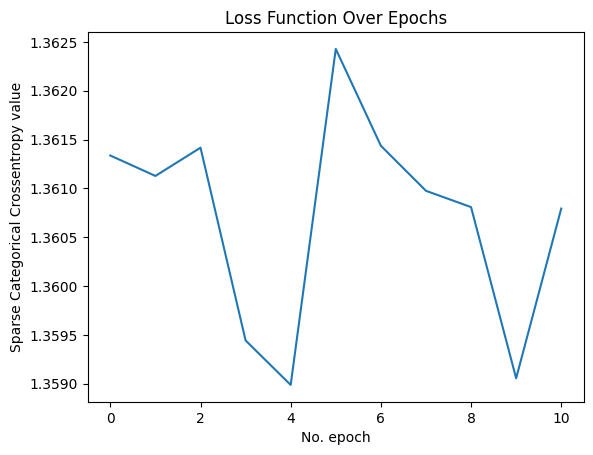

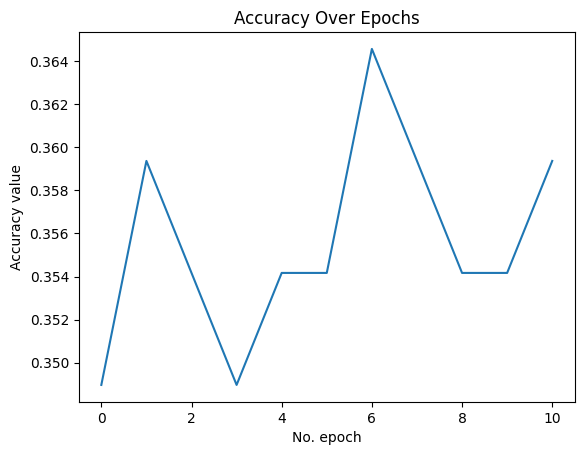

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_17[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_17[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_17[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_17[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_17[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_17[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_17[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 126,  │        448 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_1 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_2 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_3 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director            │ (None, 1, 20)     │     34,060 │ index_and_expand… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ production_company  │ (None, 1, 20)     │     19,560 │ index_and_expand… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ production_country  │ (None, 1, 20)     │      1,120 │ index_and_expand… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ domestic_distribut… │ (None, 1, 20)     │      3,960 │ index_and_expand… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │         64 │ conv2d_24[0][0] 

 Total params: 837,114 (3.19 MB)

 Trainable params: 418,444 (1.60 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 418,446 (1.60 MB)

In [129]:
best_model = load_model(best_tabular_and_poster_OUTPUT_model_path)
with open(f'./{best_tabular_and_poster_OUTPUT_model_path}_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, best_tabular_and_poster_OUTPUT_model_path, history=full_history)

## Обучение отдельно

### Интеграция на входном слое

In [130]:
best_poster_model = load_model(best_poster_model_path)

In [131]:
from keras.utils import plot_model

tabular_and_pretrained_poster_INPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='input',
        trainable=False
    ),
)
plot_model(tabular_and_pretrained_poster_INPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [132]:
train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)

optimizer = Adagrad(
    learning_rate=cfg.learning_rate,
)
tabular_and_pretrained_poster_INPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', OneClassAwayAccuracy()],
)

best_tabular_and_pretrained_poster_INPUT_model_path = f'{cfg.filename_prefix}_pretrained_input.keras'
if (not Path(best_tabular_and_pretrained_poster_INPUT_model_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_pretrained_poster_INPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=best_tabular_and_pretrained_poster_INPUT_model_path,
    )

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2791 - loss: 1.4152 - one_class_away_accuracy: 0.5350
Epoch 1: val_loss improved from inf to 1.36683, saving model to 3_bor_poster_prereleased_own_pretrained_input.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.2794 - loss: 1.4149 - one_class_away_accuracy: 0.5352 - val_accuracy: 0.3438 - val_loss: 1.3668 - val_one_class_away_accuracy: 0.5417
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3354 - loss: 1.3752 - one_class_away_accuracy: 0.5451
Epoch 2: val_loss improved from 1.36683 to 1.36420, saving model to 3_bor_poster_prereleased_own_pretrained_input.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.3354 - loss: 1.3751 - one_class_away_accuracy: 0.5452 - val_accuracy: 0.3438 - val_loss: 1.3642 - val_one_class_away_accuracy: 0.5417
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3350 - loss: 1.3699 - one_class_away_accuracy: 0.5501
Epoch 3: val_loss improved 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Exact match accuracy: 0.34375
One class away accuracy: 0.5364583333333334
Precision per class: [0.34391534 0.         0.         0.33333333]
Recall per class: [0.98484848 0.         0.         0.02439024]
F1 score per class [0.50980392 0.         0.         0.04545455]
Macro Precision: 0.1693121693121693
Macro Recall: 0.252309682187731
Macro F1: 0.1388146167557932
Micro Precision: 0.34375
Micro Recall: 0.34375
Micro F1: 0.34375


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


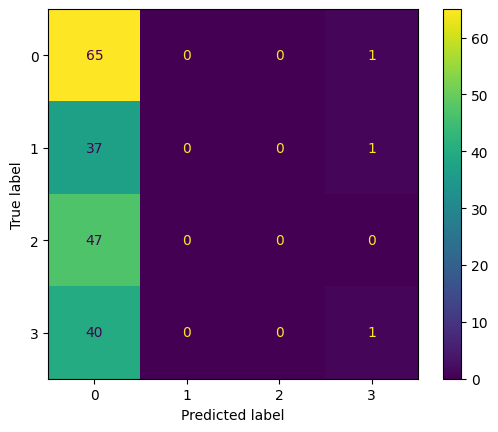

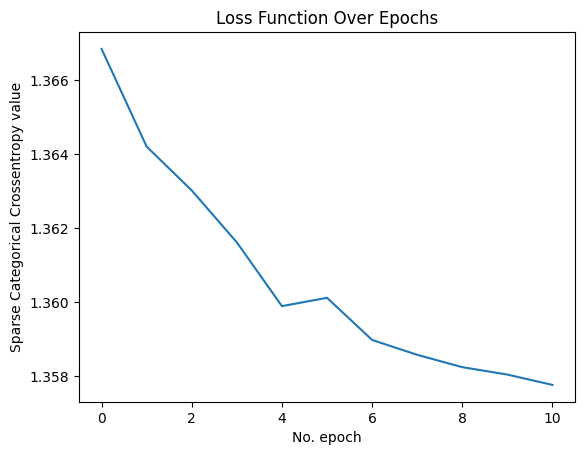

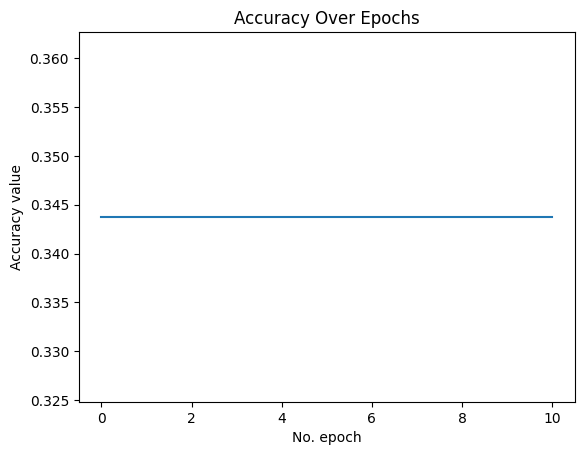

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 126,  │        448 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 42, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 40, 40,    │      4,640 │ max_pooling2d_21… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 11, 11,    │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        256 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_18[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_18[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_18[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_18[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_18[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_18[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_18[0

 Total params: 763,002 (2.91 MB)

 Trainable params: 332,556 (1.27 MB)

 Non-trainable params: 97,888 (382.38 KB)

 Optimizer params: 332,558 (1.27 MB)

In [133]:
best_model = load_model(best_tabular_and_pretrained_poster_INPUT_model_path)
with open(f'./{best_tabular_and_pretrained_poster_INPUT_model_path}_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, best_tabular_and_pretrained_poster_INPUT_model_path, history=full_history)

### Интеграция на промежуточном слое

In [134]:
from keras.utils import plot_model

tabular_and_pretrained_poster_MIDDLE_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='middle',
        trainable=False
    ),
)
plot_model(tabular_and_pretrained_poster_MIDDLE_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [135]:
train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)

optimizer = Adagrad(
    learning_rate=cfg.learning_rate,
)
tabular_and_pretrained_poster_MIDDLE_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', OneClassAwayAccuracy()],
)

best_tabular_and_pretrained_poster_MIDDLE_model_path = f'{cfg.filename_prefix}_pretrained_middle.keras'
if (not Path(best_tabular_and_pretrained_poster_MIDDLE_model_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_pretrained_poster_MIDDLE_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=best_tabular_and_pretrained_poster_MIDDLE_model_path,
    )

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2575 - loss: 1.5444 - one_class_away_accuracy: 0.7011
Epoch 1: val_loss improved from inf to 1.37193, saving model to 3_bor_poster_prereleased_own_pretrained_middle.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.2577 - loss: 1.5432 - one_class_away_accuracy: 0.7004 - val_accuracy: 0.3385 - val_loss: 1.3719 - val_one_class_away_accuracy: 0.5885
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3353 - loss: 1.3798 - one_class_away_accuracy: 0.6217
Epoch 2: val_loss improved from 1.37193 to 1.36977, saving model to 3_bor_poster_prereleased_own_pretrained_middle.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3350 - loss: 1.3799 - one_class_away_accuracy: 0.6213 - val_accuracy: 0.3385 - val_loss: 1.3698 - val_one_class_away_accuracy: 0.5417
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3300 - loss: 1.3735 - one_class_away_accuracy: 0.5923
Epoch 3: val_loss improve

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Exact match accuracy: 0.328125
One class away accuracy: 0.5729166666666666
Precision per class: [0.35416667 0.         0.28571429 0.28571429]
Recall per class: [0.77272727 0.         0.17021277 0.09756098]
F1 score per class [0.48571429 0.         0.21333333 0.14545455]
Macro Precision: 0.2313988095238095
Macro Recall: 0.26012525357361893
Macro F1: 0.2111255411255411
Micro Precision: 0.328125
Micro Recall: 0.328125
Micro F1: 0.328125


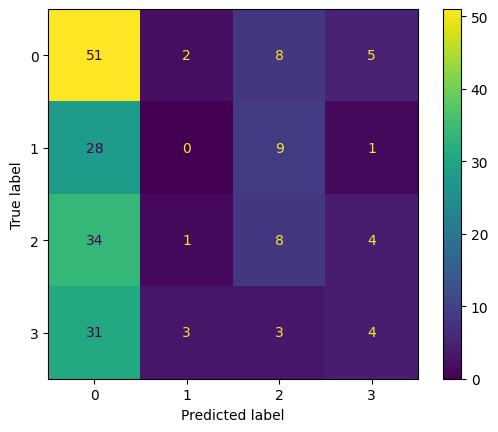

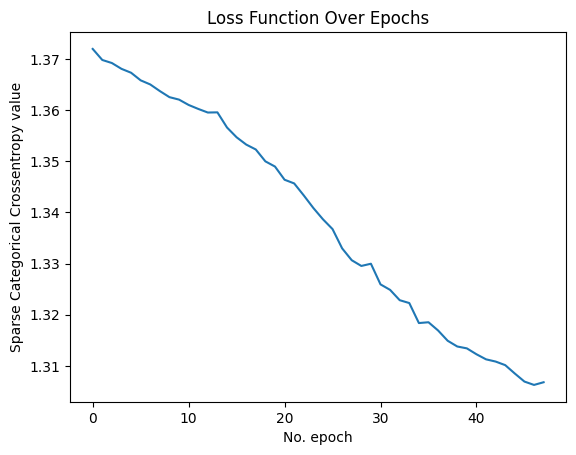

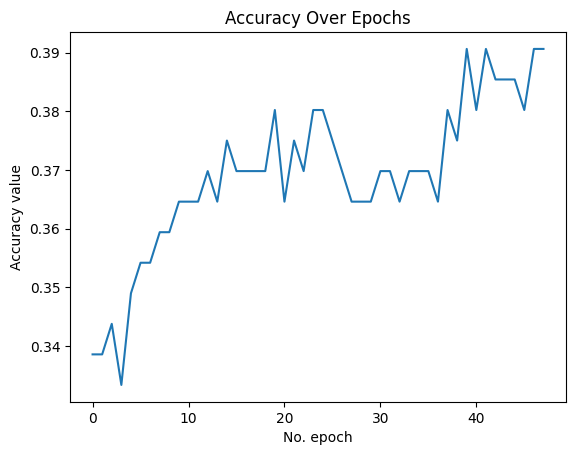

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 126,  │        448 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 42, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 40, 40,    │      4,640 │ max_pooling2d_21… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_19[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_19[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_19[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_19[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_19[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_19[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_19[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_1 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_2 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_3 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director            │ (None, 1, 20)     │     34,060 │ index_and_expand

 Total params: 746,618 (2.85 MB)

 Trainable params: 324,364 (1.24 MB)

 Non-trainable params: 97,888 (382.38 KB)

 Optimizer params: 324,366 (1.24 MB)

In [136]:
best_model = load_model(best_tabular_and_pretrained_poster_MIDDLE_model_path)
with open(f'./{best_tabular_and_pretrained_poster_MIDDLE_model_path}_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, best_tabular_and_pretrained_poster_MIDDLE_model_path, history=full_history)

### Интеграция на выходном слое

In [137]:
from keras.utils import plot_model

tabular_and_pretrained_poster_OUTPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='output',
        trainable=False
    ),
)
plot_model(tabular_and_pretrained_poster_OUTPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [138]:
train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)

optimizer = Adagrad(
    learning_rate=cfg.learning_rate,
)
tabular_and_pretrained_poster_OUTPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', OneClassAwayAccuracy()],
)

best_tabular_and_pretrained_poster_OUTPUT_model_path = f'{cfg.filename_prefix}_pretrained_output.keras'
if (not Path(best_tabular_and_pretrained_poster_OUTPUT_model_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_pretrained_poster_OUTPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=best_tabular_and_pretrained_poster_OUTPUT_model_path,
    )

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2779 - loss: 1.5117 - one_class_away_accuracy: 0.6200
Epoch 1: val_loss improved from inf to 1.45771, saving model to 3_bor_poster_prereleased_own_pretrained_output.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.2783 - loss: 1.5107 - one_class_away_accuracy: 0.6198 - val_accuracy: 0.2865 - val_loss: 1.4577 - val_one_class_away_accuracy: 0.5417
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3482 - loss: 1.3807 - one_class_away_accuracy: 0.6266
Epoch 2: val_loss improved from 1.45771 to 1.43251, saving model to 3_bor_poster_prereleased_own_pretrained_output.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.3484 - loss: 1.3803 - one_class_away_accuracy: 0.6267 - val_accuracy: 0.3125 - val_loss: 1.4325 - val_one_class_away_accuracy: 0.5312
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4011 - loss: 1.3049 - one_class_away_accuracy: 0.6392
Epoch 3: val_loss improve

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Exact match accuracy: 0.3125
One class away accuracy: 0.6510416666666666
Precision per class: [0.39393939 0.13793103 0.26829268 0.26086957]
Recall per class: [0.59090909 0.10526316 0.23404255 0.14634146]
F1 score per class [0.47272727 0.11940299 0.25       0.1875    ]
Macro Precision: 0.2652581691415933
Macro Recall: 0.2691390663524878
Macro F1: 0.25740756445047486
Micro Precision: 0.3125
Micro Recall: 0.3125
Micro F1: 0.3125


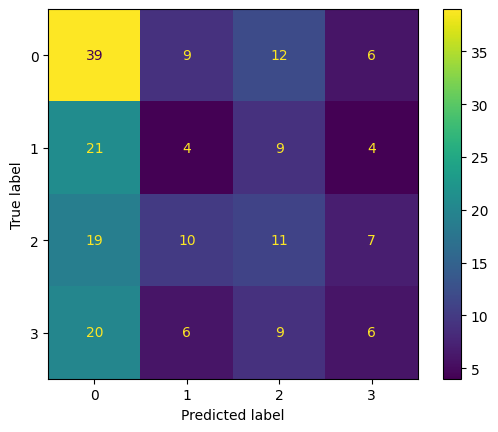

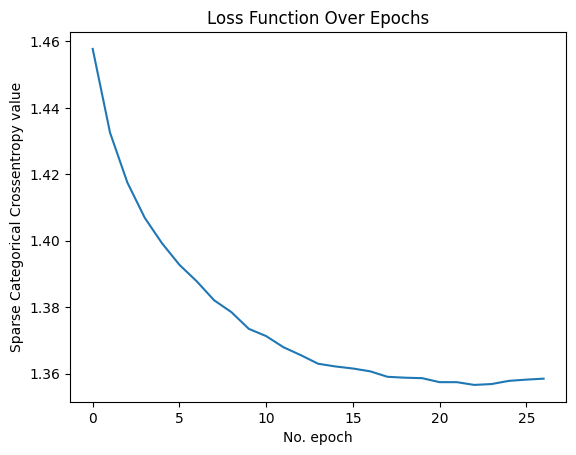

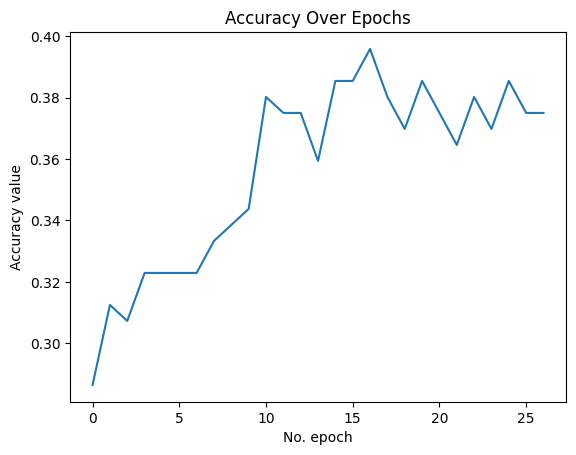

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_20[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_20[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_20[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_20[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_20[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_20[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index_and_expand_l… │ (None, 1)         │          0 │ input_layer_20[0… │
│ (IndexAndExpandLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 126,  │        448 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_1 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_2 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ actor_3 (Embedding) │ (None, 1, 20)     │     78,500 │ index_and_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director            │ (None, 1, 20)     │     34,060 │ index_and_expand… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ production_company  │ (None, 1, 20)     │     19,560 │ index_and_expand… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ production_country  │ (None, 1, 20)     │      1,120 │ index_and_expand… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ domestic_distribut… │ (None, 1, 20)     │      3,960 │ index_and_expand… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │         64 │ conv2d_24[0][0] 

 Total params: 739,450 (2.82 MB)

 Trainable params: 320,780 (1.22 MB)

 Non-trainable params: 97,888 (382.38 KB)

 Optimizer params: 320,782 (1.22 MB)

In [139]:
best_model = load_model(best_tabular_and_pretrained_poster_OUTPUT_model_path)
with open(f'./{best_tabular_and_pretrained_poster_OUTPUT_model_path}_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, best_tabular_and_pretrained_poster_OUTPUT_model_path, history=full_history)